In [1]:
import os
import glob
import math
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import clima_anom as ca
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%run ../function/function.ipynb

In [2]:
# so = 'manjaro'
so = 'xubuntu'

In [3]:
if so == 'xubuntu':
    base = '/media/'
elif so == 'manjaro':
    base = '/run/media/'
print(f'so  : {so}')
print(f'base: {base}')

so  : xubuntu
base: /media/


In [4]:
lat_c = -22.8611
lon_c = -47.0563
r = (180)/111

In [5]:
shape = list(shpreader.Reader('../mappings/SaoPaulo_Fixed.shp').geometries())

In [6]:
Brasildat_dir = base + 'arturo/Arturo/Data/BrasilDat/Campinas/2018/grid/BrasilDat_2018_03_15min_8kmx8km.nc'
Brasildat = ca.read_netcdf(Brasildat_dir,2)
lat = Brasildat['lat']
lon = Brasildat['lon']
time_B = Brasildat['time']
flash_B = Brasildat['flash']

lon2d, lat2d = np.meshgrid(lon,lat)
nt, ny, nx = np.shape(flash_B)

lat : (45,)
lon : (45,)
time : (2976,)
flash : (2976, 45, 45)


In [7]:
GLM_dir = base + 'arturo/Arturo/Data/GLM/Campinas/2018/grid/GLM_2018_03_15min_8kmx8km.nc'
GLM = ca.read_netcdf(GLM_dir,2)
flash_G = GLM['flash']

lat : (45,)
lon : (45,)
time : (2976,)
flash : (2976, 45, 45)


In [59]:
B_mean = np.nanmean(flash_B,axis=0)
G_mean = np.nanmean(flash_G,axis=0)

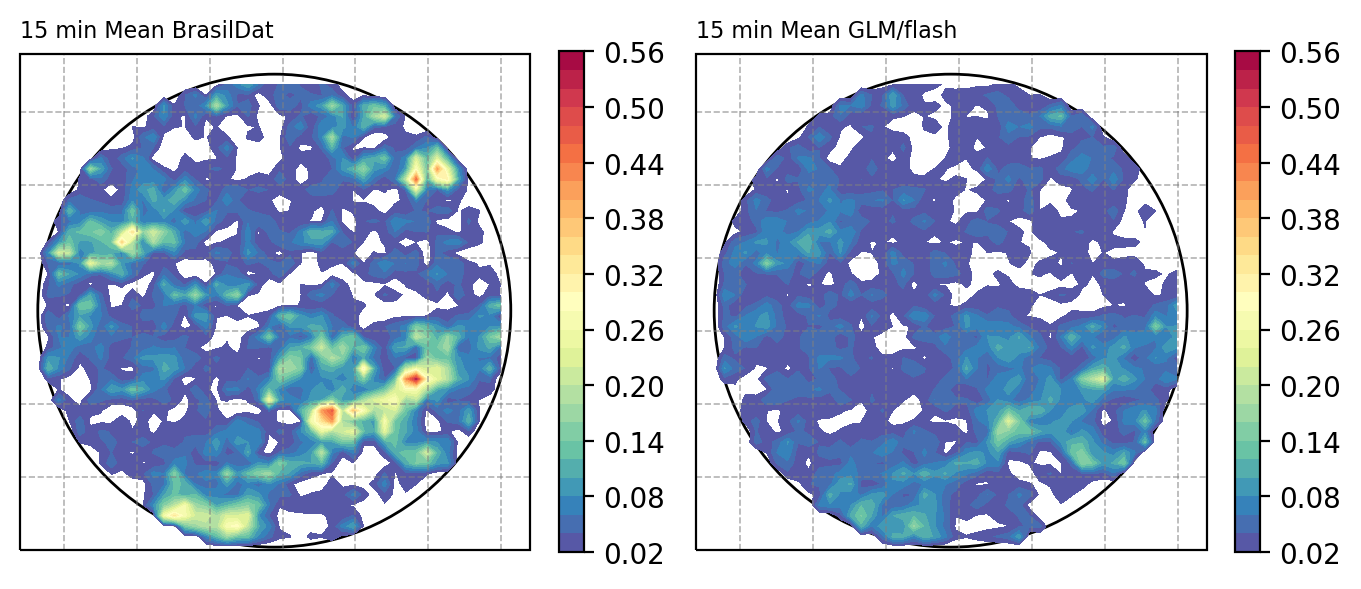

In [61]:
levels = np.arange(0.02,0.58,0.02)

circle1 = plt.Circle((lon_c,lat_c), r, color='k',fill=False)
circle2 = plt.Circle((lon_c,lat_c), r, color='k',fill=False)

fig = plt.figure(figsize=(8,4),dpi=200)
proj = ccrs.PlateCarree()
gs = gridspec.GridSpec(1,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj) 
ax1.add_artist(circle1)
a1 = plt.contourf(lon2d,lat2d,B_mean,levels=levels,cmap=plt.cm.Spectral_r)
# ax1.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax1.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax1.set_title('15 min Mean BrasilDat', loc='left', fontsize=8)
plt.colorbar(a1,fraction=0.0444)

#==================================================================================================
ax2 = plt.subplot(gs[0, 1], projection = proj) 
ax2.add_artist(circle2)
a2 = plt.contourf(lon2d,lat2d,G_mean,levels=levels,cmap=plt.cm.Spectral_r)
# ax1.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax2.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax2.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax2.set_title('15 min Mean GLM/flash', loc='left', fontsize=8)
plt.colorbar(a2,fraction=0.0444)

salida = '../images/GLM_Brasildat_15min_mean.png'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

In [28]:
flash_G_15_serie = np.reshape(flash_G,(nt*ny*nx))
flash_B_15_serie = np.reshape(flash_B,(nt*ny*nx))

In [29]:
pos = np.where(~(np.isnan(flash_B_15_serie)))[0]
flash_G_15_serie = flash_G_15_serie[pos]
flash_B_15_serie = flash_B_15_serie[pos]

## Scatter Plot all days

In [30]:
Regresion = np.zeros([3])

X_train, X_test, y_train, y_test = train_test_split(flash_G_15_serie,flash_B_15_serie, train_size = 0.9,random_state = 1234,shuffle = True)
corr_test = pearsonr(flash_G_15_serie,flash_B_15_serie)

modelo = LinearRegression()
modelo.fit(X = X_train.reshape(-1, 1), y = y_train)

Regresion[0] = corr_test[0]
Regresion[1] = modelo.coef_ #m
Regresion[2] = modelo.intercept_ #b

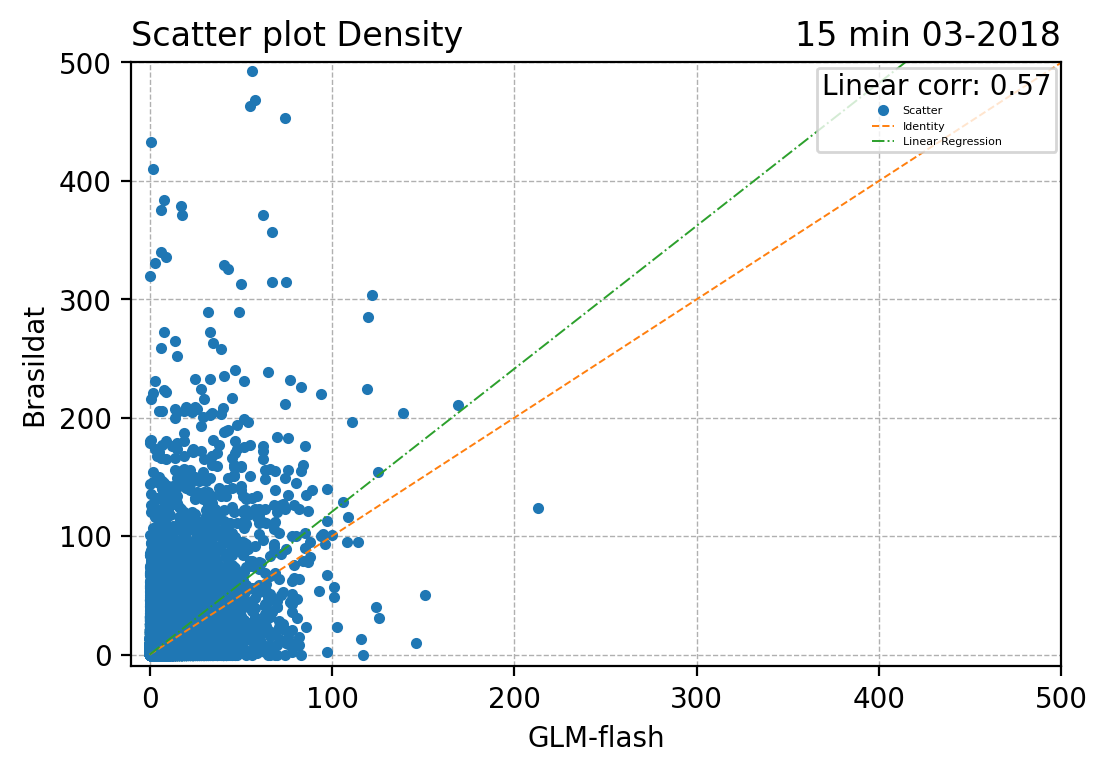

In [32]:
xx = np.arange(0,np.max(flash_B_15_serie))
yy = xx
yy_regretion = Regresion[1] * xx + Regresion[2]

fig = plt.figure(figsize=(6,4),dpi=200)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(flash_G_15_serie,flash_B_15_serie,'.',label='Scatter')
ax1.plot(xx,yy,'--',linewidth=0.7,label='Identity')
ax1.plot(xx,yy_regretion,'-.',linewidth=0.7,label='Linear Regression')

ax1.set_ylim(-10,500)
ax1.set_xlim(-10,500)

ax1.set_ylabel('Brasildat')
ax1.set_xlabel('GLM-flash')
ax1.set_title('Scatter plot Density',loc='left')
ax1.set_title('15 min 03-2018',loc='right')

leg_title = 'Linear corr: '+ str(np.round(Regresion[0],3))
legend = ax1.legend(title=leg_title,loc=1, fontsize=4)
plt.grid(linewidth=0.5,linestyle='--')

salida = '../images/Scatter_GLM_BrasilDat_15min_month.png'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

## Scatter Plot for mean

In [12]:
flash_G_15_mean = np.nansum(flash_G,axis=0)
flash_B_15_mean = np.nansum(flash_B,axis=0)

flash_G_15_mean_s = np.reshape(flash_G_15_mean,45*45)
flash_B_15_mean_s = np.reshape(flash_B_15_mean,45*45)

nan_pos = np.where(~np.isnan(flash_G_15_mean_s))[0]
flash_G_15_mean_s = flash_G_15_mean_s[nan_pos]
flash_B_15_mean_s = flash_B_15_mean_s[nan_pos]

In [23]:
Regresion = np.zeros([3])

X_train, X_test, y_train, y_test = train_test_split(flash_G_15_mean_s,flash_B_15_mean_s, train_size = 0.9,random_state = 1234,shuffle = True)
corr_test = pearsonr(flash_G_15_mean_s,flash_B_15_mean_s)

modelo = LinearRegression()
modelo.fit(X = X_train.reshape(-1, 1), y = y_train)

Regresion[0] = corr_test[0]
Regresion[1] = modelo.coef_ #m
Regresion[2] = modelo.intercept_ #b

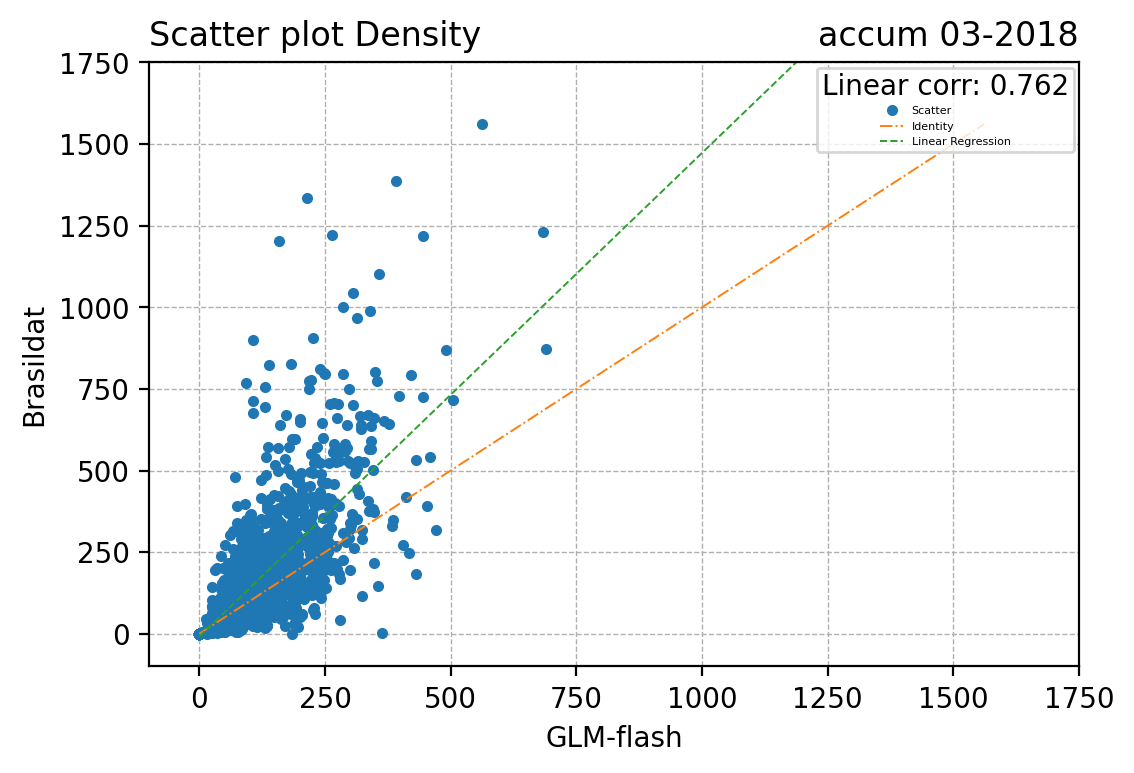

In [27]:
xx = np.arange(0,np.max(flash_B_15_mean_s))
yy = xx
yy_regretion = Regresion[1] * xx + Regresion[2]

fig = plt.figure(figsize=(6,4),dpi=200)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(flash_G_15_mean_s,flash_B_15_mean_s,'.',label='Scatter')
ax1.plot(xx,yy,'-.',linewidth=0.7,label='Identity')
ax1.plot(xx,yy_regretion,'--',linewidth=0.7,label='Linear Regression')

ax1.set_ylim(-100,1750)
ax1.set_xlim(-100,1750)

ax1.set_ylabel('Brasildat')
ax1.set_xlabel('GLM-flash')
ax1.set_title('Scatter plot Density',loc='left')
ax1.set_title('accum 03-2018',loc='right')

leg_title = 'Linear corr: '+ str(np.round(Regresion[0],3))
legend = ax1.legend(title=leg_title,loc=1, fontsize=4)
plt.grid(linewidth=0.5,linestyle='--')

salida = '../images/Scatter_GLM_BrasilDat_15min_month_acumm.png'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

## Matrix Correlation

In [33]:
matrix_cor = ca.correlation(flash_G,flash_B)

/home/arturo/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/arturo/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


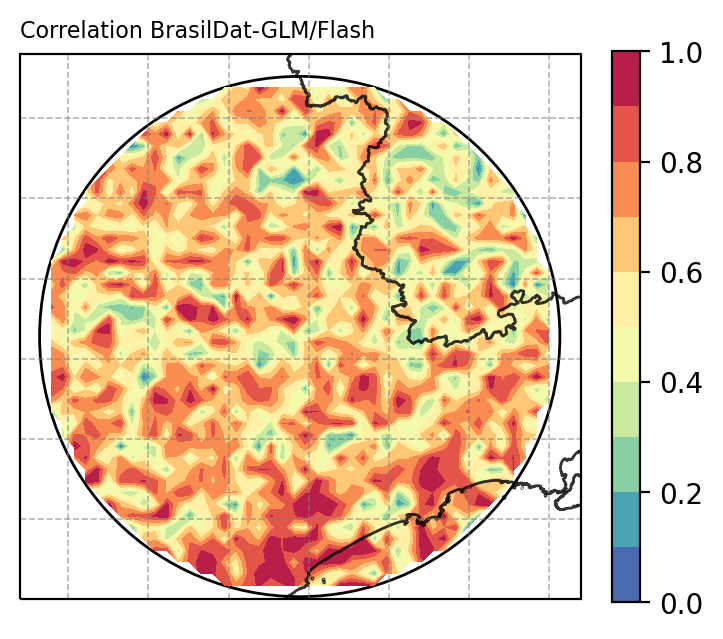

In [34]:
levels = np.arange(0,1.1,0.1)

circle1 = plt.Circle((lon_c,lat_c), r, color='k',fill=False)
circle2 = plt.Circle((lon_c,lat_c), r, color='k',fill=False)

fig = plt.figure(figsize=(4,4),dpi=200)
proj = ccrs.PlateCarree()
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0], projection = proj) 
ax1.add_artist(circle1)
a1 = plt.contourf(lon2d,lat2d,matrix_cor,levels=levels,cmap=plt.cm.Spectral_r)
ax1.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax1.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax1.set_title('Correlation BrasilDat-GLM/Flash', loc='left', fontsize=8)
plt.colorbar(a1,fraction=0.0444)

salida = '../images/GLM_Brasildat_15min_Corr.png'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

## RMSE and BIAS

In [70]:
RMSE = ca.RMSE(flash_G,flash_B)

In [71]:
BIAS = np.zeros([ny,nx])
for i in range(ny):
    for j in range(nx):
        dif_tmp = np.sum(flash_G[:,i,j] - flash_B[:,i,j])
        BIAS[i,j] = dif_tmp/nt

In [72]:
cmap_RMSE = plt.cm.Spectral_r
cmap_RMSE2 = ca.colorbar_middle_white(cmap_RMSE,position='left')

cmap_ref = plt.cm.bwr
cmap_BIAS = ca.colorbar_middle_white(cmap_ref,position='middle')

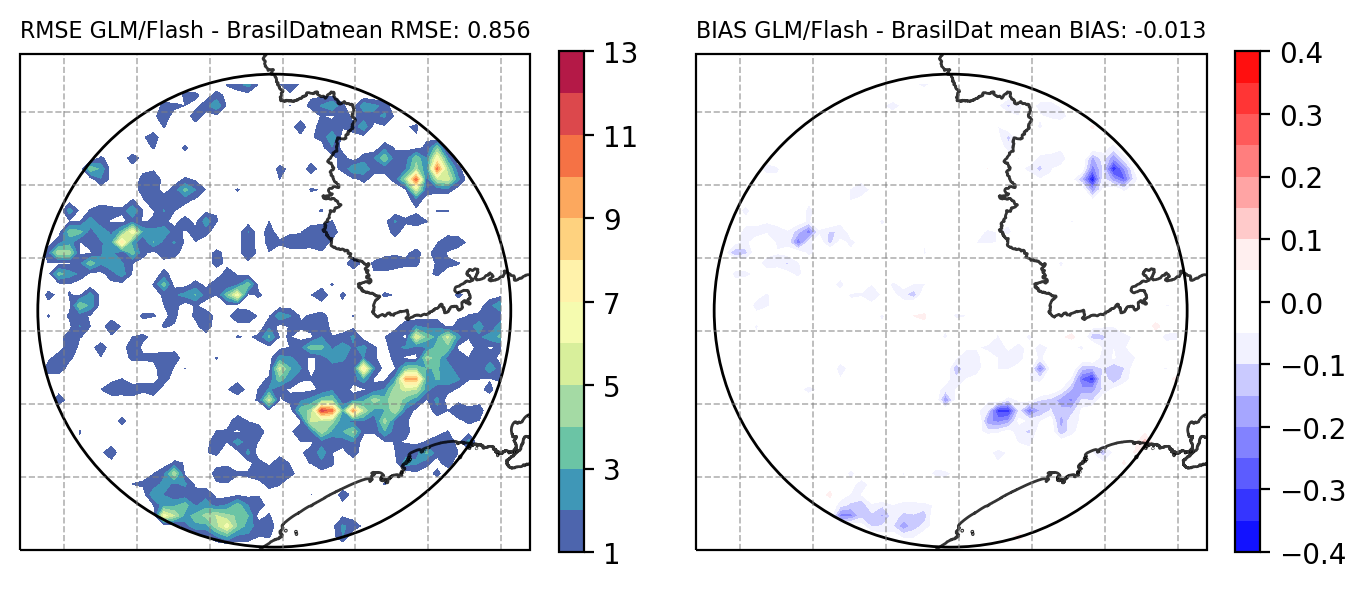

In [73]:
levels = np.arange(1,14,1)
levels_BIAS = np.arange(-0.4,0.45,0.05)

circle1 = plt.Circle((lon_c,lat_c), r, color='k',fill=False)
circle2 = plt.Circle((lon_c,lat_c), r, color='k',fill=False)

fig = plt.figure(figsize=(8,6),dpi=200)
proj = ccrs.PlateCarree()
gs = gridspec.GridSpec(1,2)

RMSE_mean = np.round(np.nanmean(RMSE),3)
BIAS_mean = np.round(np.nanmean(BIAS),3)

ax1 = plt.subplot(gs[0, 0], projection = proj) 
a1 = plt.contourf(lon2d,lat2d,RMSE,levels=levels,cmap=cmap_RMSE)
ax1.add_artist(circle1)
ax1.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax1.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax1.set_title('RMSE GLM/Flash - BrasilDat', loc='left', fontsize=8)
RMSE_title = 'mean RMSE: '+ str(RMSE_mean)
ax1.set_title(RMSE_title, loc='right', fontsize=8)
plt.colorbar(a1,fraction=0.0444)

ax2 = plt.subplot(gs[0, 1], projection = proj) 
a2 = plt.contourf(lon2d,lat2d,BIAS,levels=levels_BIAS,cmap=cmap_BIAS)
ax2.add_artist(circle2)
ax2.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax2.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax2.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax2.set_title('BIAS GLM/Flash - BrasilDat', loc='left', fontsize=8)
BIAS_title = 'mean BIAS: '+ str(BIAS_mean)
ax2.set_title(BIAS_title, loc='right', fontsize=8)
plt.colorbar(a2,fraction=0.0444)
np.arange(-0.6,0.7,0.1)

salida = '../images/GLM_Brasildat_15min_RMSE_BIAS.png'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

## Daily Accumulated

In [66]:
brasildat_24h = np.zeros(24)
for d in range(24):
    hour_accum = 0
    for t in range(nt):
        if time_B[t].hour == d:
            tmp = np.nansum(flash_B[t,:,:])
            hour_accum = hour_accum + tmp
    brasildat_24h[d] = hour_accum

In [67]:
GLM_24h = np.zeros(24)
for d in range(24):
    hour_accum = 0
    for t in range(nt):
        if time_B[t].hour == d:
            tmp = np.nansum(flash_G[t,:,:])
            hour_accum = hour_accum + tmp
    GLM_24h[d] = hour_accum

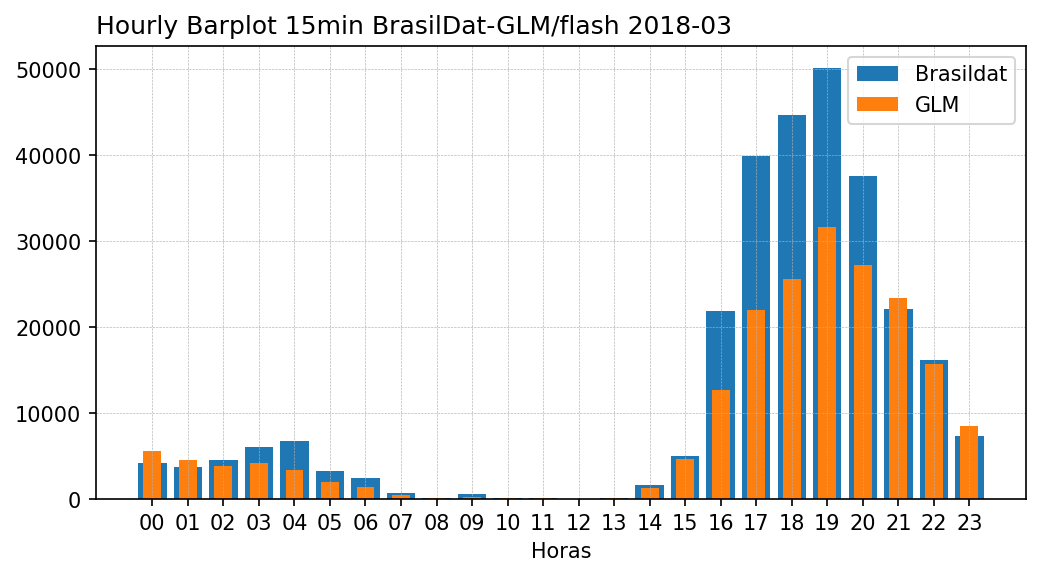

In [68]:
fig = plt.figure(figsize=(8,4),dpi=150)
x = np.arange(24)

plt.bar(x,brasildat_24h,label='Brasildat')
plt.bar(x,GLM_24h,label='GLM',width=0.5)

plt.xticks(x, ('00','01','02','03','04','05','06','07','08','09','10','11','12',
               '13','14','15','16','17','18','19','20','21','22','23'))
plt.xlabel('Horas')
plt.grid(True,linewidth=0.3,linestyle='--')
plt.legend()
plt.title('Hourly Barplot 15min BrasilDat-GLM/flash 2018-03',loc='left')

salida = '../images/GLM_Brasildat_15min_barplot.png'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

## BrasilDat - GLM

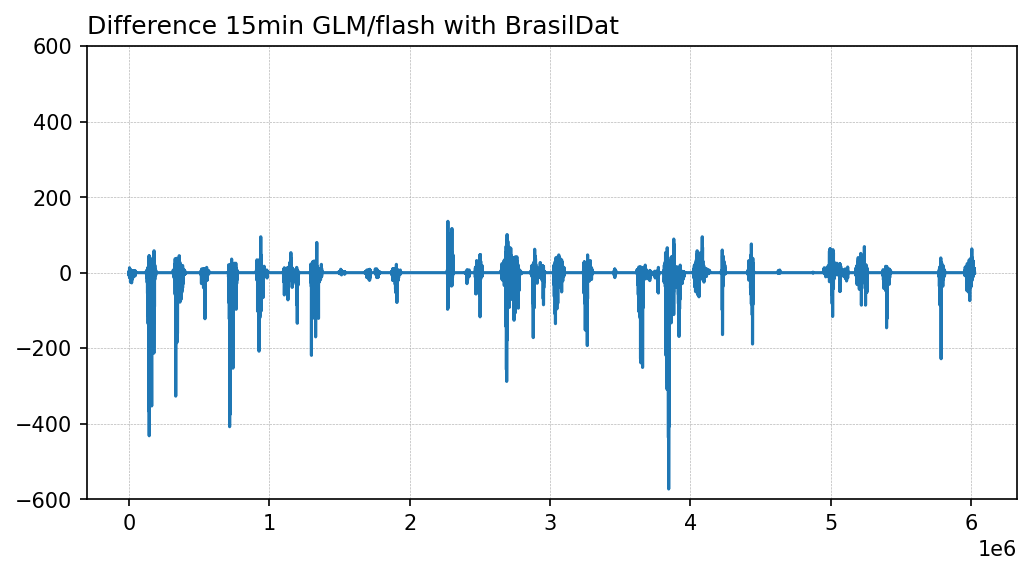

In [76]:
fig = plt.figure(figsize=(8,4),dpi=150)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0]) 
ax1.plot(flash_G_15_serie - flash_B_15_serie)
ax1.set_title('Difference 15min GLM/flash with BrasilDat', loc='left')

plt.ylim(-600,600)
plt.grid(linewidth=0.3, linestyle='--')

salida = '../images/GLM_Brasildat_15min_diff.png'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

In [56]:
pos_zeros = np.where(flash_G_15_serie!=0)[0]
flash_G_15_serie_NoZeros = flash_G_15_serie[pos_zeros]
pos_zeros = np.where(flash_B_15_serie!=0)[0]
flash_B_15_serie_NoZeros = flash_B_15_serie[pos_zeros]

In [57]:
data_2d=[flash_B_15_serie_NoZeros, flash_G_15_serie_NoZeros]

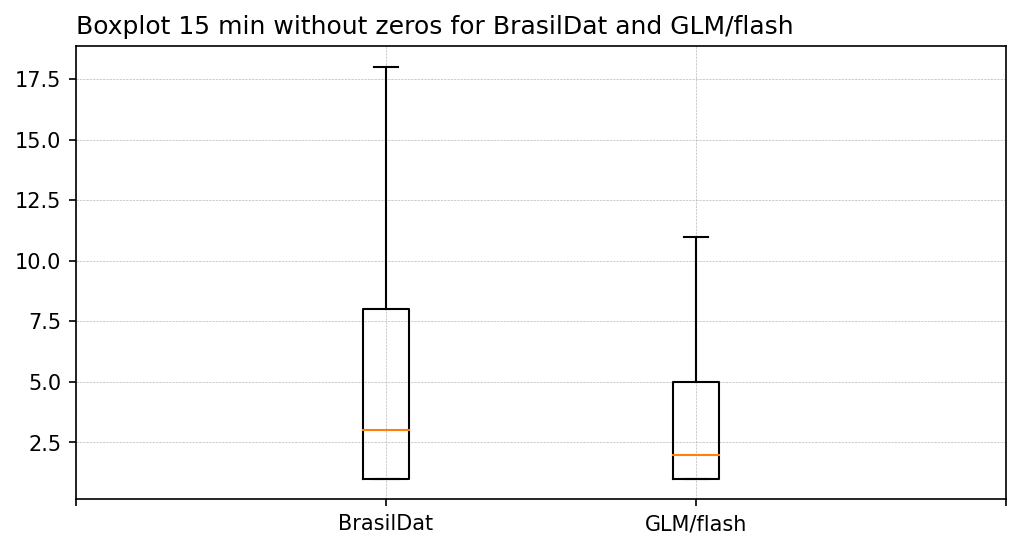

In [75]:
fig = plt.figure(figsize=(8,4),dpi=150)
gs = gridspec.GridSpec(1,1)

x = np.arange(4)

ax1 = plt.subplot(gs[0, 0]) 
ax1.boxplot(data_2d,showfliers=False)
plt.grid(True,linewidth=0.3,linestyle='--')
plt.xticks(x, ('','BrasilDat','GLM/flash',''))
plt.title('Boxplot 15 min without zeros for BrasilDat and GLM/flash',loc='left')

salida = '../images/GLM_Brasildat_15min_boxplot.png'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')